In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#import lightgbm as lgb

%matplotlib inline

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(500, input_dim=38, input_length=100))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 500)               1078000   
Total params: 1,078,000
Trainable params: 1,078,000
Non-trainable params: 0
_________________________________________________________________


In [8]:
import tensorflow as tf
tfd = tf.contrib.distributions

def make_encoder(data, code_size):
    x = tf.layers.flatten(data)
    x = tf.layers.dense(x, 200, tf.nn.relu)
    x = tf.layers.dense(x, 200, tf.nn.relu)
    loc = tf.layers.dense(x, code_size)
    scale = tf.layers.dense(x, code_size, tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scale)
def make_prior(code_size):
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale)
import numpy as np

def make_decoder(code, data_shape):
    x = code
    x = tf.layers.dense(x, 200, tf.nn.relu)
    x = tf.layers.dense(x, 200, tf.nn.relu)
    logit = tf.layers.dense(x, np.prod(data_shape))
    logit = tf.reshape(logit, [-1] + data_shape)
    return tfd.Independent(tfd.Bernoulli(logit), 2)

make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

data = tf.placeholder(tf.float32, [None, 28, 28])

prior = make_prior(code_size=2)
posterior = make_encoder(data, code_size=2)
code = posterior.sample()

likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)
samples = make_decoder(prior.sample(10), [28, 28]).mean()

total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print(total_parameters)

# from tensorflow.examples.tutorials.mnist import input_data

# mnist = input_data.read_data_sets('MNIST_data/')

# with tf.train.MonitoredSession() as sess:
#     for epoch in range(20):
#         test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], {data: mnist.test.images})
#         print('Epoch', epoch, 'elbo', test_elbo)
#         plot_codes(test_codes)
#         plot_sample(test_samples)
#     for _ in range(600):
#         sess.run(optimize, {data: mnist.train.next_batch(100)[0]})


8880636


In [3]:
df = pd.read_csv('Bank-loan-prediction/loan_table.csv', encoding='latin-1', header=0)
# header = 0 means the first role is the index
# header = None means no header

In [4]:
df

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0
...,...,...,...,...,...
101095,734902,emergency_funds,2012-01-30,1,0.0
101096,712467,business,2012-11-22,1,0.0
101097,209268,other,2012-09-13,1,1.0
101098,779254,business,2012-02-08,1,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   loan_id       101100 non-null  int64  
 1   loan_purpose  101100 non-null  object 
 2   date          101100 non-null  object 
 3   loan_granted  101100 non-null  int64  
 4   loan_repaid   47654 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.9+ MB


In [6]:
df.describe()

,loan_id,loan_granted,loan_repaid
count,101100.000000,101100.000000,47654.000000
mean,499666.826726,0.471355,0.644353
std,288662.006929,0.499181,0.478714
min,30.000000,0.000000,0.000000
25%,250333.750000,0.000000,0.000000
50%,499885.000000,0.000000,1.000000
75%,749706.250000,1.000000,1.000000
max,999987.000000,1.000000,1.000000


In [7]:
df.isnull().sum()

loan_id             0
loan_purpose        0
date                0
loan_granted        0
loan_repaid     53446
dtype: int64

In [8]:
df2 = pd.read_csv('Bank-loan-prediction/borrower_table.csv', encoding='latin-1', header=0)

In [9]:
df2

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1
...,...,...,...,...,...,...,...,...,...,...,...,...
101095,38238,1,NaN,NaN,2200,0.83,1295,2240,0,0,47,2
101096,590712,1,NaN,NaN,3800,0.70,340,3802,1,36100,41,7
101097,961276,1,NaN,NaN,1600,1.06,445,1757,1,40800,71,3
101098,551027,0,1.0,0.0,7000,0.82,354,1435,1,41900,44,2


In [11]:
df2.describe()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
count,101100.000000,101100.000000,46153.000000,46153.000000,101100.000000,94128.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000
mean,499666.826726,0.543492,0.899291,0.364332,4112.743818,0.724140,1799.617616,3177.150821,0.658675,21020.727992,41.491632,3.864748
std,288662.006929,0.498107,0.300946,0.481247,2129.121462,0.186483,1400.545141,2044.448155,0.474157,18937.581415,12.825570,2.635491
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000
25%,250333.750000,0.000000,1.000000,0.000000,2700.000000,0.600000,834.000000,1706.000000,0.000000,0.000000,32.000000,2.000000
50%,499885.000000,1.000000,1.000000,0.000000,4100.000000,0.730000,1339.000000,2673.000000,1.000000,21500.000000,41.000000,3.000000
75%,749706.250000,1.000000,1.000000,1.000000,5500.000000,0.860000,2409.000000,4241.000000,1.000000,35300.000000,50.000000,6.000000
max,999987.000000,1.000000,1.000000,1.000000,13500.000000,1.090000,10641.000000,13906.000000,1.000000,97200.000000,79.000000,8.000000


In [12]:
df2.isnull().sum()

loan_id                                                0
is_first_loan                                          0
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year     6972
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
dtype: int64

In [25]:
pay_back = df.loan_repaid[df.loan_granted==1]
pay_back

3         1.0
4         0.0
6         1.0
7         0.0
8         1.0
         ... 
101094    0.0
101095    0.0
101096    0.0
101097    1.0
101098    1.0
Name: loan_repaid, Length: 47654, dtype: float64

In [35]:
total_revenue = sum(pay_back==1)-sum(pay_back==0)
print(total_revenue) 
# the total revenue is $13758 

13758


In [34]:
# out of people who were granted the loan, 64% of them paid back and the rest did not pay back
pay_back.value_counts(normalize=True)

13758


1.0    0.644353
0.0    0.355647
Name: loan_repaid, dtype: float64

In [46]:
data = pd.merge(df2, df, on = 'loan_id')


In [47]:
data

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_purpose,date,loan_granted,loan_repaid
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3,business,2012-01-31,0,NaN
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1,investment,2012-11-02,0,NaN
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8,other,2012-07-16,1,1.0
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1,investment,2012-06-05,0,NaN
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1,emergency_funds,2012-11-28,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101095,38238,1,NaN,NaN,2200,0.83,1295,2240,0,0,47,2,other,2012-12-24,0,NaN
101096,590712,1,NaN,NaN,3800,0.70,340,3802,1,36100,41,7,business,2012-05-17,1,1.0
101097,961276,1,NaN,NaN,1600,1.06,445,1757,1,40800,71,3,other,2012-09-07,0,NaN
101098,551027,0,1.0,0.0,7000,0.82,354,1435,1,41900,44,2,investment,2012-08-23,1,0.0


In [52]:
granted_pop = data[data.loan_granted==1]

In [53]:
granted_pop.is_employed

2         1
5         1
7         1
8         1
9         1
         ..
101089    1
101090    1
101096    1
101098    1
101099    1
Name: is_employed, Length: 47654, dtype: int64

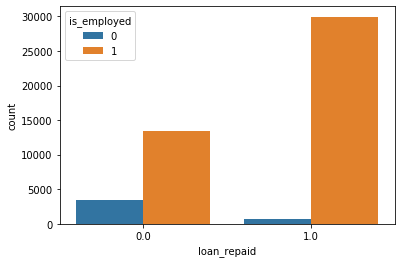

In [55]:
# look at how emplyeement affect the decision making of the bank
sns.countplot(granted_pop['loan_repaid'],hue=granted_pop['is_employed'])


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 0 to 101099
Data columns (total 16 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   is_first_loan                                    101100 non-null  int64  
 2   fully_repaid_previous_loans                      46153 non-null   float64
 3   currently_repaying_other_loans                   46153 non-null   float64
 4   total_credit_card_limit                          101100 non-null  int64  
 5   avg_percentage_credit_card_limit_used_last_year  94128 non-null   float64
 6   saving_amount                                    101100 non-null  int64  
 7   checking_amount                                  101100 non-null  int64  
 8   is_employed                                      101100 non-null  int64  
 9   yearly_salary  

In [58]:
data.describe()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_granted,loan_repaid
count,101100.000000,101100.000000,46153.000000,46153.000000,101100.000000,94128.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,47654.000000
mean,499666.826726,0.543492,0.899291,0.364332,4112.743818,0.724140,1799.617616,3177.150821,0.658675,21020.727992,41.491632,3.864748,0.471355,0.644353
std,288662.006929,0.498107,0.300946,0.481247,2129.121462,0.186483,1400.545141,2044.448155,0.474157,18937.581415,12.825570,2.635491,0.499181,0.478714
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000
25%,250333.750000,0.000000,1.000000,0.000000,2700.000000,0.600000,834.000000,1706.000000,0.000000,0.000000,32.000000,2.000000,0.000000,0.000000
50%,499885.000000,1.000000,1.000000,0.000000,4100.000000,0.730000,1339.000000,2673.000000,1.000000,21500.000000,41.000000,3.000000,0.000000,1.000000
75%,749706.250000,1.000000,1.000000,1.000000,5500.000000,0.860000,2409.000000,4241.000000,1.000000,35300.000000,50.000000,6.000000,1.000000,1.000000
max,999987.000000,1.000000,1.000000,1.000000,13500.000000,1.090000,10641.000000,13906.000000,1.000000,97200.000000,79.000000,8.000000,1.000000,1.000000


In [59]:
data.isnull().sum()

loan_id                                                0
is_first_loan                                          0
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year     6972
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
loan_repaid                                        53446
dtype: int64

In [69]:
data.avg_percentage_credit_card_limit_used_last_year.isnull()

0         False
1         False
2         False
3         False
4         False
          ...  
101095    False
101096    False
101097    False
101098    False
101099    False
Name: avg_percentage_credit_card_limit_used_last_year, Length: 101100, dtype: bool

In [77]:
data.avg_percentage_credit_card_limit_used_last_year[data.avg_percentage_credit_card_limit_used_last_year.isnull()] = 0.0

In [78]:
data.avg_percentage_credit_card_limit_used_last_year.isnull().sum()

0

In [79]:
data.isnull().sum()

loan_id                                                0
is_first_loan                                          0
fully_repaid_previous_loans                        54947
currently_repaying_other_loans                     54947
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year        0
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
loan_repaid                                        53446
dtype: int64

In [80]:
# now start to do feature engineering

In [85]:
data.fully_repaid_previous_loans = data.fully_repaid_previous_loans.fillna(0.0)

In [87]:
data.fully_repaid_previous_loans = data.fully_repaid_previous_loans.astype(int)
data.fully_repaid_previous_loans.dtype

dtype('int64')

In [90]:
data.currently_repaying_other_loans = data.currently_repaying_other_loans.fillna(0.0)
data.currently_repaying_other_loans = data.currently_repaying_other_loans.astype(int)
data.currently_repaying_other_loans.dtype


dtype('int64')

In [91]:
data

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_purpose,date,loan_granted,loan_repaid
0,289774,1,0,0,8000,0.49,3285,1073,0,0,47,3,business,2012-01-31,0,NaN
1,482590,0,1,0,4500,1.03,636,5299,1,13500,33,1,investment,2012-11-02,0,NaN
2,135565,1,0,0,6900,0.82,2085,3422,1,24500,38,8,other,2012-07-16,1,1.0
3,207797,0,1,0,1200,0.82,358,3388,0,0,24,1,investment,2012-06-05,0,NaN
4,828078,0,0,0,6900,0.80,2138,4282,1,18100,36,1,emergency_funds,2012-11-28,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101095,38238,1,0,0,2200,0.83,1295,2240,0,0,47,2,other,2012-12-24,0,NaN
101096,590712,1,0,0,3800,0.70,340,3802,1,36100,41,7,business,2012-05-17,1,1.0
101097,961276,1,0,0,1600,1.06,445,1757,1,40800,71,3,other,2012-09-07,0,NaN
101098,551027,0,1,0,7000,0.82,354,1435,1,41900,44,2,investment,2012-08-23,1,0.0


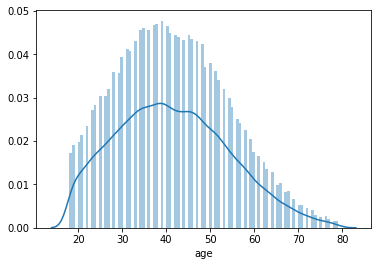

In [95]:
sns.distplot(data.age, bins=100) 
plt.show()

In [101]:
# bin the age into groups
# bins 20-29, 30-39, 40-49, n bins, n-1 labels
data['age_group'] =pd.cut(x=data['age'], bins=[0, 19, 29, 39, 49, 59, 69,100], labels=['below20s', '20s', '30s', '40s', '50s', '60s', 'above60s'])

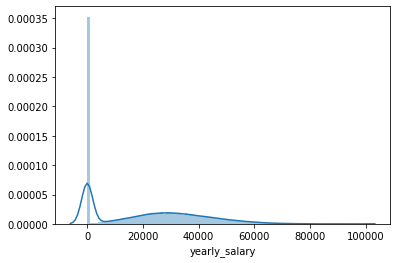

In [105]:
sns.distplot(data.yearly_salary, bins=100) 
plt.show()

In [ ]:
# bin the age into groups
# bins n bins, n-1 labels
data['age_group'] =pd.cut(x=data['age'], bins=[0, 10000, 2000, 3000, 4000, 59, 69,100], labels=['below20s', '20s', '30s', '40s', '50s', '60s', 'above60s'])

In [107]:
category_data  = ['age_group','loan_purpose']

In [109]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in category_data:
    data[col] = le.fit_transform(data[col])



In [118]:
data.loan_granted.value_counts()

0    53446
1    47654
Name: loan_granted, dtype: int64

In [122]:
data['date'] = pd.to_datetime(data.date)

In [126]:
data['month'] = data.date.dt.month
data['dayofweek'] = data.date.dt.weekday
data['week'] = data['date'].apply(lambda x: x.week)



In [130]:
#data = data.drop(['weekday'],axis = 1)

In [131]:
data

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_purpose,date,loan_granted,loan_repaid,age_group,dayofweek,month,week
0,289774,1,0,0,8000,0.49,3285,1073,0,0,47,3,0,2012-01-31,0,NaN,2,1,1,5
1,482590,0,1,0,4500,1.03,636,5299,1,13500,33,1,3,2012-11-02,0,NaN,1,4,11,44
2,135565,1,0,0,6900,0.82,2085,3422,1,24500,38,8,4,2012-07-16,1,1.0,1,0,7,29
3,207797,0,1,0,1200,0.82,358,3388,0,0,24,1,3,2012-06-05,0,NaN,0,1,6,23
4,828078,0,0,0,6900,0.80,2138,4282,1,18100,36,1,1,2012-11-28,0,NaN,1,2,11,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101095,38238,1,0,0,2200,0.83,1295,2240,0,0,47,2,4,2012-12-24,0,NaN,2,0,12,52
101096,590712,1,0,0,3800,0.70,340,3802,1,36100,41,7,0,2012-05-17,1,1.0,2,3,5,20
101097,961276,1,0,0,1600,1.06,445,1757,1,40800,71,3,4,2012-09-07,0,NaN,5,4,9,36
101098,551027,0,1,0,7000,0.82,354,1435,1,41900,44,2,3,2012-08-23,1,0.0,2,3,8,34


In [135]:
data['loan_repaid']

0         NaN
1         NaN
2         1.0
3         NaN
4         NaN
         ... 
101095    NaN
101096    1.0
101097    NaN
101098    0.0
101099    1.0
Name: loan_repaid, Length: 101100, dtype: float64

In [138]:
data['loan_repaid'] = data['loan_repaid'].map({np.nan:2, 1.0:1, 0.0:0})

In [139]:
# now I need to select only the data that is being granted 
df_grant = data[data.loan_granted==1]

In [140]:
df_grant

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,loan_purpose,date,loan_granted,loan_repaid,age_group,dayofweek,month,week
2,135565,1,0,0,6900,0.82,2085,3422,1,24500,38,8,4,2012-07-16,1,1,1,0,7,29
5,423171,1,0,0,6100,0.53,6163,5298,1,29500,24,1,4,2012-11-07,1,1,0,2,11,45
7,200139,1,0,0,4000,0.57,602,2757,1,31700,36,8,0,2012-09-19,1,0,1,2,9,38
8,991294,0,1,0,7000,0.52,2575,2917,1,58900,33,3,1,2012-12-04,1,1,1,1,12,49
9,875332,0,1,0,4300,0.83,722,892,1,5400,32,7,0,2012-01-20,1,1,1,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101089,697542,1,0,0,2800,0.82,1485,798,1,22200,40,3,4,2012-03-27,1,0,2,1,3,13
101090,20065,0,1,0,3000,0.67,635,3335,1,7800,41,3,0,2012-12-04,1,0,2,1,12,49
101096,590712,1,0,0,3800,0.70,340,3802,1,36100,41,7,0,2012-05-17,1,1,2,3,5,20
101098,551027,0,1,0,7000,0.82,354,1435,1,41900,44,2,3,2012-08-23,1,0,2,3,8,34


In [189]:
sns.countplot(df_grant['loan_purpose'],hue=df_grant['loan_repaid'],ax=a)



In [188]:
# lets see the effect of these parameters
sns.countplot(df_grant['is_employed'],hue=df_grant['loan_repaid'],ax=a)
plt.show()

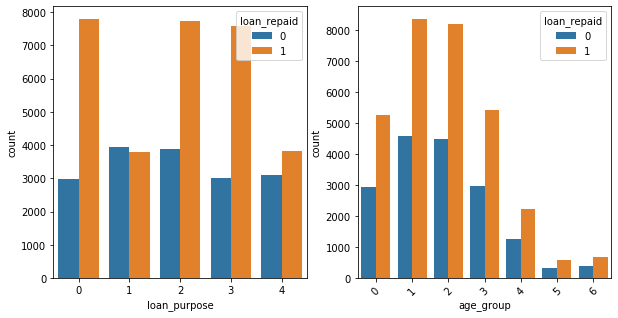

In [145]:
# lets see the effect of these parameters
fig, ((a,b)) = plt.subplots(1,2,figsize=(10,5))
plt.xticks(rotation=45)
sns.countplot(df_grant['loan_purpose'],hue=df_grant['loan_repaid'],ax=a)
sns.countplot(df_grant['age_group'],hue=df_grant['loan_repaid'],ax=b)


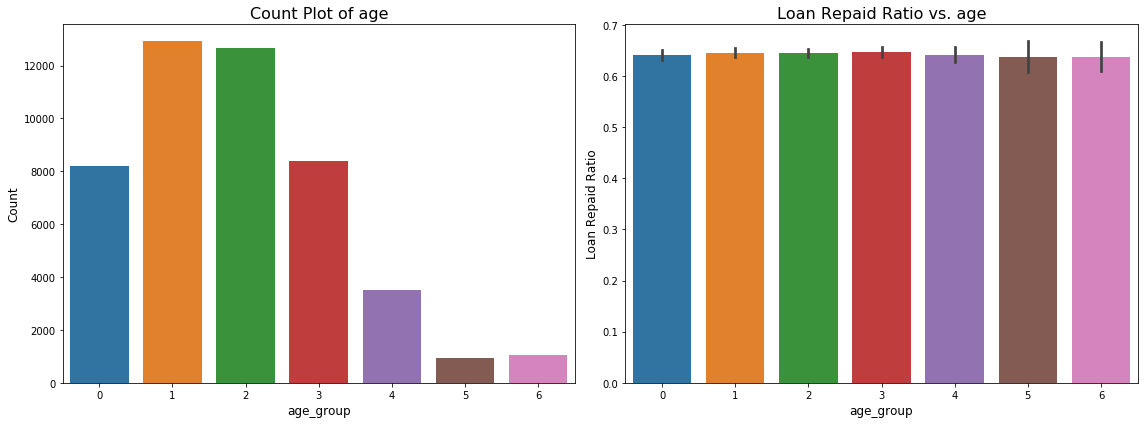

In [285]:
# visualization of 'age'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='age_group', data=df_grant, ax=ax[0])
ax[0].set_xlabel('age_group', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of age', fontsize=16)

sns.barplot(x='age_group', y='loan_repaid', data=df_grant, ax=ax[1])
ax[1].set_xlabel('age_group', fontsize=12)
ax[1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1].set_title('Loan Repaid Ratio vs. age', fontsize=16)
plt.tight_layout()
plt.show()

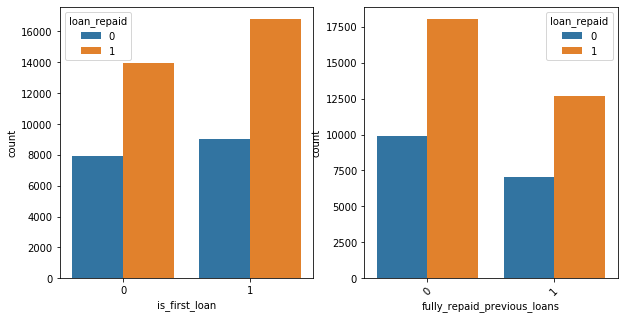

In [152]:
# lets see the effect of these parameters
fig, ((a,b)) = plt.subplots(1,2,figsize=(10,5))
plt.xticks(rotation=45)
sns.countplot(df_grant['is_first_loan'],hue=df_grant['loan_repaid'],ax=a)
sns.countplot(df_grant['fully_repaid_previous_loans'],hue=df_grant['loan_repaid'],ax=b)

# the first time applied has slightedly higher pay back rate
# whehter you have fully paid previous loan does not really matter

In [146]:
# conclusion from the count plot:
# pay back rate is usually higher for purpose 1,3,4
# younger people has a slight higher payback rate

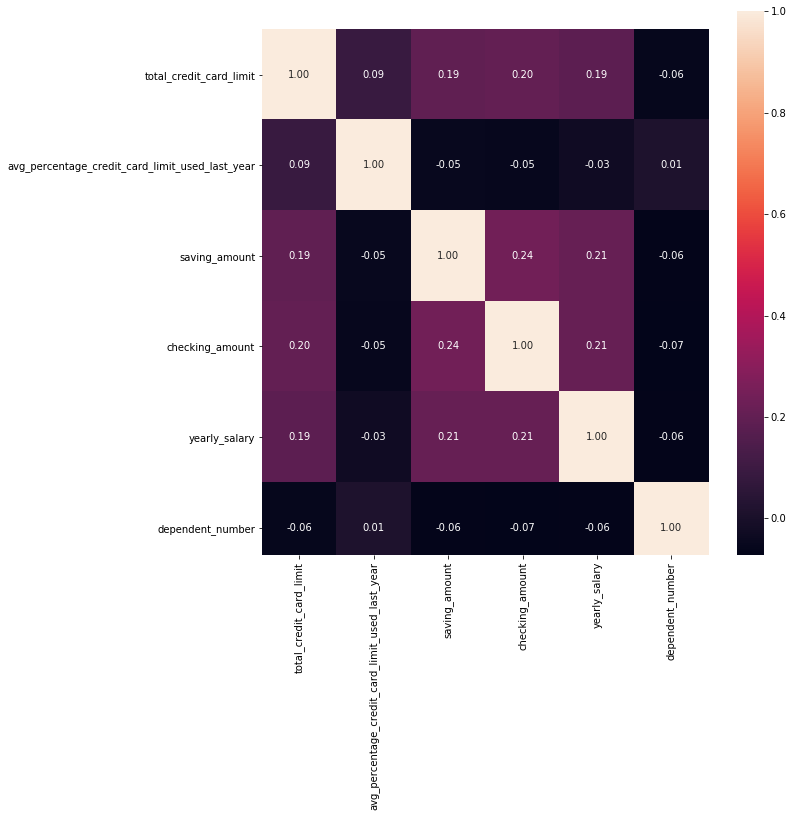

In [190]:
# do a correlation plot for numerical features

numeric_features=[  'total_credit_card_limit',
       'avg_percentage_credit_card_limit_used_last_year', 'saving_amount',
       'checking_amount', 'yearly_salary',
       'dependent_number']
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df_grant[numeric_features].corr(), annot=True, fmt ='.2f')
ax.set_ylim(len(numeric_features)-0.2, -0.2) # heatmap visualization issue quick fix 
plt.show()

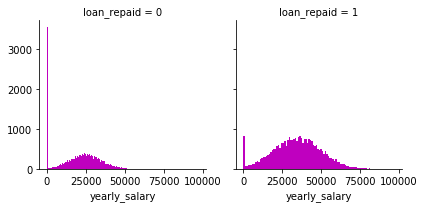

In [158]:
# x is numerical, y is categories, can use facet plot
g = sns.FacetGrid(df_grant, col="loan_repaid", col_order=[0, 1])
g = g.map(plt.hist, "yearly_salary", bins=100, color="m")



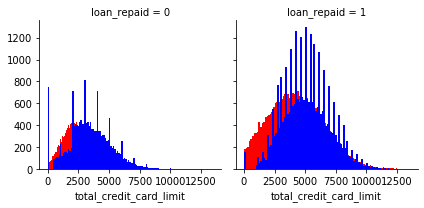

In [159]:
# x is numerical, y is categories, can use facet plot
g = sns.FacetGrid(df_grant, col="loan_repaid", col_order=[0, 1])
g = g.map(plt.hist, "checking_amount", bins=100, color="r")
g = g.map(plt.hist, "total_credit_card_limit", bins=100, color="b")


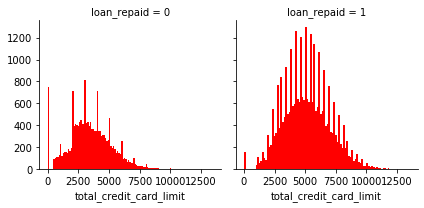

In [160]:
g = sns.FacetGrid(df_grant, col="loan_repaid", col_order=[0, 1])
g = g.map(plt.hist, "total_credit_card_limit", bins=100, color="r")

In [162]:
# below we can start running models
df_grant.columns

Index(['loan_id', 'is_first_loan', 'fully_repaid_previous_loans',
       'currently_repaying_other_loans', 'total_credit_card_limit',
       'avg_percentage_credit_card_limit_used_last_year', 'saving_amount',
       'checking_amount', 'is_employed', 'yearly_salary', 'age',
       'dependent_number', 'loan_purpose', 'date', 'loan_granted',
       'loan_repaid', 'age_group', 'dayofweek', 'month', 'week'],
      dtype='object')

In [163]:
features=['is_first_loan', 'fully_repaid_previous_loans',
       'currently_repaying_other_loans', 'total_credit_card_limit',
       'avg_percentage_credit_card_limit_used_last_year', 'saving_amount',
       'checking_amount', 'is_employed', 'yearly_salary',
       'dependent_number', 'loan_purpose', 'age_group', 'dayofweek', 'month', 'week']

In [166]:
X = df_grant[features]

In [169]:
Y = df_grant['loan_repaid']
Y

2         1
5         1
7         0
8         1
9         1
         ..
101089    0
101090    0
101096    1
101098    0
101099    1
Name: loan_repaid, Length: 47654, dtype: int64

In [263]:
Y_train

71910    0
25120    0
90963    0
46805    0
19413    1
        ..
92794    1
68761    0
11038    0
25778    1
69847    0
Name: loan_repaid, Length: 38123, dtype: int64

In [171]:
validation_size = 0.20 # 20% of data is used for validation
seed = 1
num_folds = 5
scoring = 'accuracy'
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y, test_size=validation_size, random_state=seed)

In [178]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, roc_auc_score,roc_curve, auc
# random forest is the best out of all
random_forest = RandomForestClassifier(n_estimators=250,max_features=5)
random_forest.fit(X_train, Y_train)
predictions = random_forest.predict(X_validation)
print("Accuracy: %s%%" % (100*accuracy_score(Y_validation, predictions)))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

Accuracy: 91.86863917742104%
[[3089  313]
 [ 462 5667]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3402
           1       0.95      0.92      0.94      6129

    accuracy                           0.92      9531
   macro avg       0.91      0.92      0.91      9531
weighted avg       0.92      0.92      0.92      9531



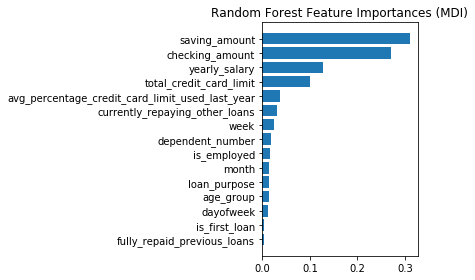

In [180]:
# get feature importance from random forest
importances = random_forest.feature_importances_
sorted_idx = importances.argsort()
feature_names0 = [features[i] for i in sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[sorted_idx])
ax.set_yticklabels(feature_names0)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [195]:
# Now lets try use xgboost
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_validation, label=Y_validation)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [200]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1.0, 'nthread': 2, 'booster' : 'gbtree', 'silent': 1,
            'objective': 'reg:linear','eval_metric': 'error'} 
model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
      maximize=False, verbose_eval=1)
print('Modeling error %.5f' % model.best_score)

[0]	train-error:0.124833	valid-error:0.13199
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 50 rounds.
[1]	train-error:0.127167	valid-error:0.140384
[2]	train-error:0.11796	valid-error:0.13304
[3]	train-error:0.112583	valid-error:0.126115
[4]	train-error:0.10857	valid-error:0.123597
[5]	train-error:0.103507	valid-error:0.117616
[6]	train-error:0.103114	valid-error:0.117931
[7]	train-error:0.102982	valid-error:0.117826
[8]	train-error:0.09493	valid-error:0.111006
[9]	train-error:0.083703	valid-error:0.099255
[10]	train-error:0.078509	valid-error:0.095478
[11]	train-error:0.074915	valid-error:0.091281
[12]	train-error:0.073656	valid-error:0.090337
[13]	train-error:0.071427	valid-error:0.088133
[14]	train-error:0.069354	valid-error:0.08635
[15]	train-error:0.065787	valid-error:0.082992
[16]	train-error:0.064712	valid-error:0.083202
[17]	train-error:0.06382	valid-error:0.082678
[18]	train-error:0.06237

In [205]:
X_train

,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,dependent_number,loan_purpose,age_group,dayofweek,month,week
71910,0,1,1,3400,0.62,794,618,1,7400,1,0,3,0,3,11
25120,1,0,0,2400,0.86,1166,3963,1,25200,1,0,0,0,9,37
90963,1,0,0,3500,0.28,940,2333,1,26300,8,3,1,2,8,34
46805,0,1,1,6300,0.84,1380,1749,1,21800,8,0,3,2,7,29
19413,1,0,0,5600,0.20,4743,2772,1,59200,1,0,3,0,4,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92794,0,1,0,2500,0.79,3608,5767,1,39400,1,3,2,0,9,39
68761,1,0,0,3000,0.97,1728,2770,1,34900,5,4,1,1,8,32
11038,1,0,0,6700,0.72,2077,1758,1,32800,4,0,2,4,10,40
25778,1,0,0,6300,0.76,1932,3759,1,19100,4,0,0,2,12,51


In [214]:
y_pred = model.predict(dvalid)

In [215]:
y_pred

array([0.71971494, 0.65069747, 1.0045748 , ..., 0.27313498, 0.20601267,
       0.09023985], dtype=float32)

In [216]:
predictions = [round(value) for value in y_pred]

In [ ]:
# # result from random forest
# Accuracy: 91.86863917742104%
# [[3089  313]
#  [ 462 5667]]
#               precision    recall  f1-score   support

#            0       0.87      0.91      0.89      3402
#            1       0.95      0.92      0.94      6129

#     accuracy                           0.92      9531
#    macro avg       0.91      0.92      0.91      9531
# weighted avg       0.92      0.92      0.92      9531

In [217]:
# the result shows that the result using xgboost is comaprable to random forest. 
# there are more false negatives than false positives 
# confusion matrix
print("Accuracy: %s%%" % (100*accuracy_score(Y_validation, predictions)))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))


Accuracy: 91.79519462805582%
[[3077  325]
 [ 457 5672]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      3402
           1       0.95      0.93      0.94      6129

    accuracy                           0.92      9531
   macro avg       0.91      0.91      0.91      9531
weighted avg       0.92      0.92      0.92      9531



In [220]:
# compute the area under the ROC curve
roc_auc_score(Y_validation, y_pred)

0.9719735993597962

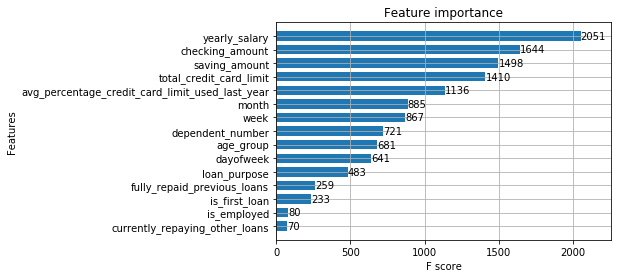

In [201]:
xgb.plot_importance(model, max_num_features=28, height=0.7)


In [ ]:
# how to plot ROC, AUC F1 score after xgboost?
# how xgboost works and how to set parameters
# get to know LightBGM and isolation forest
# get to know NER.

In [223]:
Y_validation

14284    1
86442    1
23339    1
11696    0
6997     0
        ..
2913     1
28341    0
44538    0
90794    0
55257    0
Name: loan_repaid, Length: 9531, dtype: int64

In [231]:
y_pred.ravel()

array([0.71971494, 0.65069747, 1.0045748 , ..., 0.27313498, 0.20601267,
       0.09023985], dtype=float32)

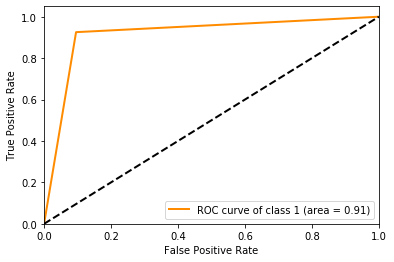

In [290]:
# two classes ROC curve

num_labels = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(Y_validation, predictions) # Y_validation is golden label, predictions is the probability 
roc_auc = auc(fpr, tpr)


colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
plt.plot(fpr, tpr, color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [242]:
roc_auc

{0: 0.91495220484452,
 1: 0.91495220484452,
 'micro': 0.91495220484452,
 'macro': 0.91495220484452}

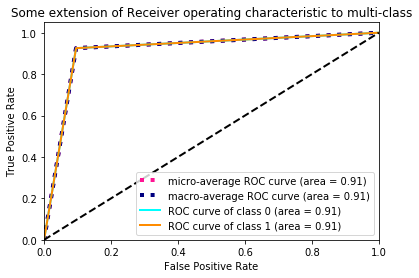

In [235]:
import itertools
# calculate roc auc
num_labels = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(Y_validation, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_validation.ravel(), np.array(predictions).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()



In [ ]:
print("Accuracy: %s%%" % (100*accuracy_score(Y_validation, predictions)))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

In [239]:
roc_auc[1]

0.91495220484452

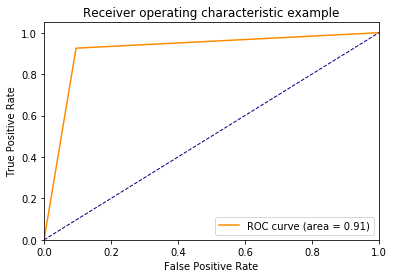

In [287]:
plt.figure()
lw = 1
plt.plot(fpr[0], tpr[0], color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [255]:
Y_validation

14284    1
86442    1
23339    1
11696    0
6997     0
        ..
2913     1
28341    0
44538    0
90794    0
55257    0
Name: loan_repaid, Length: 9531, dtype: int64

In [280]:
from sklearn.metrics import precision_recall_curve


precision, recall, thresholds = precision_recall_curve(Y_validation, y_pred)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.64332948 0.64329204 0.64335958 ... 1.         1.         1.        ]
recall: [1.00000000e+00 9.99836841e-01 9.99836841e-01 ... 3.26317507e-04
 1.63158753e-04 0.00000000e+00]
fscore: [0.8872549  0.93551047]
support: [3402 6129]


In [281]:
thresholds

array([-0.26271537, -0.2493967 , -0.24784705, ...,  1.2721626 ,
        1.2849704 ,  1.2969393 ], dtype=float32)

In [282]:
y_pred

array([0.71971494, 0.65069747, 1.0045748 , ..., 0.27313498, 0.20601267,
       0.09023985], dtype=float32)

In [283]:
Y_validation

14284    1
86442    1
23339    1
11696    0
6997     0
        ..
2913     1
28341    0
44538    0
90794    0
55257    0
Name: loan_repaid, Length: 9531, dtype: int64

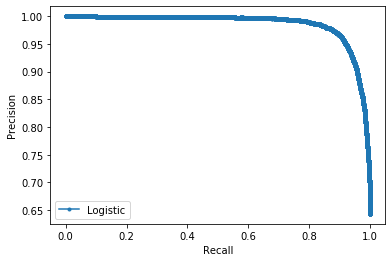

In [284]:
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [291]:
# micro and macro 
# then xgboost parameters
# 用regex 去掉sentence里面的数字，他说我写的太复杂。。。。
import re
re.sub(r'([a-z])\1+', r'\1', 'ffffffbbbbbbbqqq')
'fbq'

'fbq'

In [ ]:
# xgboost and its parameters